<a href="https://colab.research.google.com/github/nahlasadaldeen/datasets/blob/master/my_mura_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis

In [1]:
import os
import time
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision import transforms
from collections import defaultdict
from torchvision.datasets.folder import pil_loader
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
from skimage import io, transform

pd.set_option('max_colwidth', 800)

%matplotlib inline

## Load Data

We have seven categories of musculoskeletal radiographs

In [ ]:
 ! wget https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
 ! unzip -q MURA-v1.1.zip
! ls

In [8]:
#! ls MURA-v1.1


train_df = pd.read_csv('MURA-v1.1/train_labeled_studies.csv', names=['Path', 'Label'])
valid_df = pd.read_csv('MURA-v1.1/valid_labeled_studies.csv', names=['Path', 'Label'])

Let's checkout the shapes of dataframes

In [9]:
train_df.shape, valid_df.shape

((13457, 2), (1199, 2))

We have 37111 radiographs for training and 3225 radiographs for validation set, let's peak into the dataframes

In [10]:
train_df.head(3)

,Path,Label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1


In [11]:
valid_df.head(3)

,Path,Label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_positive/,1


So, we have radiograph paths and their correspoinding labels, each radiographs has a label of 0 (normal) or 1 (abnormal)

## Analysis

According to paper: <br>
1.

    The MURA abnormality detection task is a binary classification task, where the input is an upper 
    exremity radiograph study — with each study containing one or more views (images) — and the 
    expected output is a binary label y ∈ {0, 1} indicating whether the "study" is normal or abnormal, 
    respectively.
2.

    The model takes as input one or more views for a study of an upper extremity. On each view, our 169-
    layer convolutional neural network predicts the probability of abnormality. We compute the overall 
    probability of abnormality for the study by taking the arithmetic mean of the abnormality 
    probabilities output by the network for each image. The model makes the binary prediction of 
    abnormal if the probability of abnormality for the study is greater than 0.5.

So, we have make predictions on study level, taking into account the predictions of all the views (images) of the study. This can be done by taking arithmetic mean of all the views (images) under a particular study.

In [12]:
train_df.head(30)

,Path,Label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1
5,MURA-v1.1/train/XR_SHOULDER/patient00006/study1_positive/,1
6,MURA-v1.1/train/XR_SHOULDER/patient00007/study1_positive/,1
7,MURA-v1.1/train/XR_SHOULDER/patient00007/study2_negative/,0
8,MURA-v1.1/train/XR_SHOULDER/patient00008/study1_positive/,1
9,MURA-v1.1/train/XR_SHOULDER/patient00009/study1_positive/,1


Analyzing this dataframe, we can see that images are annotated based on whether their corresponding study is positive (normal, 0) or negative (abnormal, 1)

### Plot some random radiographs from training and validation set

In [15]:
train_mat = train_df.values
valid_mat = valid_df.values

['MURA-v1.1/train/XR_SHOULDER/patient00154/study1_positive/image1.png', 'MURA-v1.1/train/XR_SHOULDER/patient00154/study1_positive/image4.png', 'MURA-v1.1/train/XR_SHOULDER/patient00154/study1_positive/image3.png', 'MURA-v1.1/train/XR_SHOULDER/patient00154/study1_positive/image2.png']


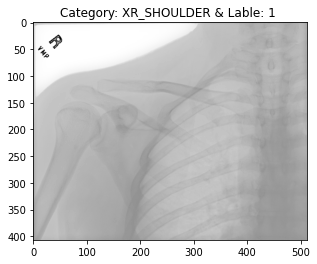

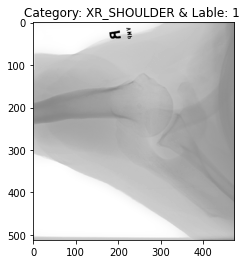

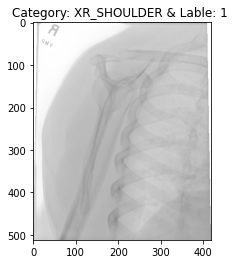

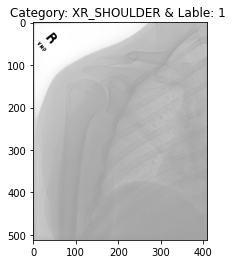

4


In [37]:
ix = np.random.randint(0, len(train_mat)) # randomly select a index
img_path = train_mat[ix][0]
data_paths = [i for i in (os.path.join(img_path, f) for f in os.listdir(img_path)) if os.path.isfile(i)]
print(data_paths)
print(len(data_paths))
for im1 in data_paths:
  im=io.imread(im1,plugin='matplotlib')
  plt.imshow(im, cmap='binary')
  cat = img_path.split('/')[2] # get the radiograph category
  plt.title('Category: %s & Lable: %d ' %(cat, train_mat[ix][1]))
  plt.show()


['MURA-v1.1/valid/XR_FINGER/patient11300/study3_negative/image1.png', 'MURA-v1.1/valid/XR_FINGER/patient11300/study3_negative/image3.png', 'MURA-v1.1/valid/XR_FINGER/patient11300/study3_negative/image2.png']
3


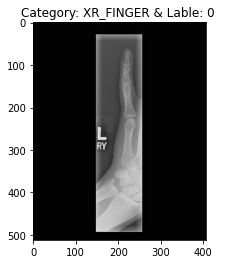

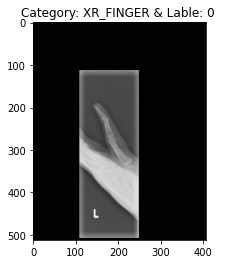

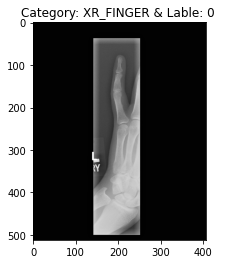

In [39]:
ix = np.random.randint(0, len(valid_mat))
img_path = valid_mat[ix][0]
data_paths = [i for i in (os.path.join(img_path, f) for f in os.listdir(img_path)) if os.path.isfile(i)]
print(data_paths)
print(len(data_paths))
for im1 in data_paths:
  im=io.imread(im1,plugin='matplotlib')
  plt.imshow(im, cmap='binary')
  cat = img_path.split('/')[2] # get the radiograph category
  plt.title('Category: %s & Lable: %d ' %(cat, valid_mat[ix][1]))
  plt.show()

This can be seen that images vary in resolution and dimension

In [42]:
# look at the pixel values
#io.imread(img_path)[0]
data_paths = [i for i in (os.path.join(img_path, f) for f in os.listdir(img_path)) if os.path.isfile(i)]
print(data_paths)
print(len(data_paths))
for im1 in data_paths:
  im=io.imread(im1,plugin='matplotlib')
  print(im)

['MURA-v1.1/valid/XR_FINGER/patient11300/study3_negative/image1.png', 'MURA-v1.1/valid/XR_FINGER/patient11300/study3_negative/image3.png', 'MURA-v1.1/valid/XR_FINGER/patient11300/study3_negative/image2.png']
3
[[[0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  ...
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]]

 [[0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  ...
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]]

 [[0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  ...
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]]

 ...

 [[0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.0078

### Data Exploration

In [44]:
!ls MURA-v1.1/train/

XR_ELBOW  XR_FINGER  XR_FOREARM  XR_HAND  XR_HUMERUS  XR_SHOULDER  XR_WRIST


In [45]:
!ls MURA-v1.1/train/XR_ELBOW/

patient00011  patient04991  patient05334  patient05677	patient06020
patient00016  patient04992  patient05335  patient05678	patient06021
patient00026  patient04993  patient05336  patient05679	patient06022
patient00031  patient04994  patient05337  patient05680	patient06023
patient00034  patient04995  patient05338  patient05681	patient06024
patient00044  patient04996  patient05339  patient05682	patient06025
patient00069  patient04997  patient05340  patient05683	patient06026
patient00147  patient04998  patient05341  patient05684	patient06027
patient00148  patient04999  patient05342  patient05685	patient06028
patient00164  patient05000  patient05343  patient05686	patient06029
patient00180  patient05001  patient05344  patient05687	patient06030
patient00196  patient05002  patient05345  patient05688	patient06031
patient00222  patient05003  patient05346  patient05689	patient06032
patient00238  patient05004  patient05347  patient05690	patient06033
patient00266  patient05005  patient05348  patien

So, train dataset has seven study types, each study type has studies on patients stored in folders named like patient001, patient002 etc..

#### Patient count per study type

Let's count number of patients in each study type

In [46]:
data_cat= ['train', 'valid']
study_types = list(os.walk('MURA-v1.1/train/'))[0][1] # study types, same for train and valid sets
patients_count = {}  # to store all patients count for each study type, for train and valid sets
for phase in data_cat:
    patients_count[phase] = {}
    for study_type in study_types:
        patients = list(os.walk('MURA-v1.1/%s/%s' %(phase, study_type)))[0][1] # patient folder names
        patients_count[phase][study_type] = len(patients)

In [47]:
print(study_types)
print()
print(patients_count)

['XR_HUMERUS', 'XR_FOREARM', 'XR_ELBOW', 'XR_HAND', 'XR_WRIST', 'XR_SHOULDER', 'XR_FINGER']

{'train': {'XR_HUMERUS': 587, 'XR_FOREARM': 865, 'XR_ELBOW': 1711, 'XR_HAND': 1945, 'XR_WRIST': 3267, 'XR_SHOULDER': 2694, 'XR_FINGER': 1865}, 'valid': {'XR_HUMERUS': 132, 'XR_FOREARM': 129, 'XR_ELBOW': 152, 'XR_HAND': 159, 'XR_WRIST': 207, 'XR_SHOULDER': 173, 'XR_FINGER': 166}}


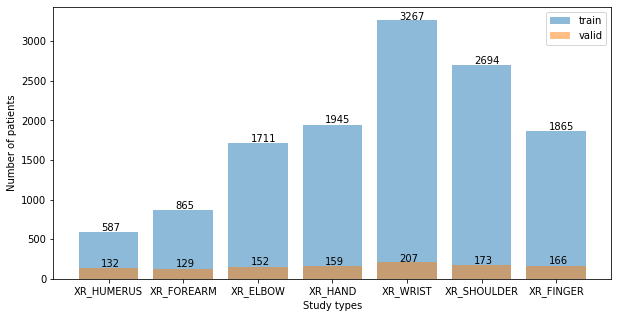

In [49]:
# plot the patient counts per study type 

fig, ax = plt.subplots(figsize=(10, 5))
for i, phase in enumerate(data_cat):
    counts = patients_count[phase].values()
    m = max(counts)
    for i, v in enumerate(counts):
        if v==m: ax.text(i-0.1, v+3, str(v))
        else: ax.text(i-0.1, v + 20, str(v))
    x_pos = np.arange(len(study_types))
    plt.bar(x_pos, counts, alpha=0.5)
    plt.xticks(x_pos, study_types)

plt.xlabel('Study types')
plt.ylabel('Number of patients')
plt.legend(['train', 'valid'])
plt.show()
#fig.savefig('images/pcpst.jpg', bbox_inches='tight', pad_inches=0) # name=patient count per study type

XR_FINGER has got the most number of patients (1867 in train set, 166 in valid set) followed by XR_WRIST

### Study count

Patients might have multiple studies for a given study type, like a patient may have two studies for wrist, independent of each other. <br> Let's have a look at such cases, **NOTE** here study count = number of patients which have same number of studies

In [50]:
# let's find out number of studies per study_type
study_count = {} # to store study counts for each study type 
for study_type in study_types:
    BASE_DIR = 'MURA-v1.1/train/%s/' % study_type
    study_count[study_type] = defaultdict(lambda:0) # to store study count for current study_type, initialized to 0 by default
    patients = list(os.walk(BASE_DIR))[0][1] # patient folder names
    for patient in patients:
        studies = os.listdir(BASE_DIR+patient)
        study_count[study_type][len(studies)] += 1

In [51]:
study_count

{'XR_ELBOW': defaultdict(<function __main__.<lambda>>, {1: 1669, 2: 41, 3: 1}),
 'XR_FINGER': defaultdict(<function __main__.<lambda>>,
             {1: 1799, 2: 62, 3: 4}),
 'XR_FOREARM': defaultdict(<function __main__.<lambda>>, {1: 853, 2: 12}),
 'XR_HAND': defaultdict(<function __main__.<lambda>>, {1: 1875, 2: 67, 3: 3}),
 'XR_HUMERUS': defaultdict(<function __main__.<lambda>>, {1: 582, 2: 5}),
 'XR_SHOULDER': defaultdict(<function __main__.<lambda>>,
             {1: 2582, 2: 101, 3: 7, 4: 4}),
 'XR_WRIST': defaultdict(<function __main__.<lambda>>,
             {1: 3094, 2: 157, 3: 12, 4: 4})}

XR_WRIST has 3111 patients who have only single study, similarly, 158 patients have 2 studies, 12 patients have 3 studies and 4 patients have 4 studies. <br> let's plot this data

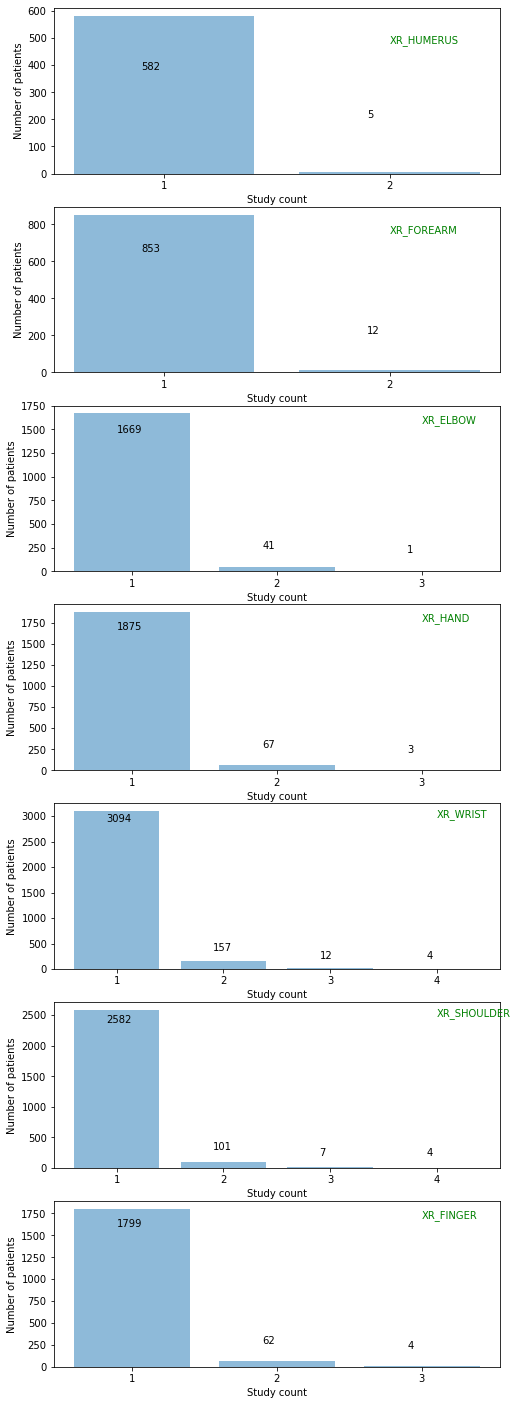

In [52]:
# plot the study count vs number of patients per study type data 
fig = plt.figure(figsize=(8, 25))
for i, study_type in enumerate(study_count):
    ax = fig.add_subplot(7, 1, i+1)
    study = study_count[study_type]
    # text in the plot
    m = max(study.values())
    for i, v in enumerate(study.values()):
        if v==m: ax.text(i-0.1, v - 200, str(v))
        else: ax.text(i-0.1, v + 200, str(v))
    ax.text(i, m - 100, study_type, color='green')
    # plot the bar chart
    x_pos = np.arange(len(study))
    plt.bar(x_pos, study.values(), align='center', alpha=0.5)
    plt.xticks(x_pos,  study.keys())
    plt.xlabel('Study count')
    plt.ylabel('Number of patients')
plt.show()
#fig.savefig('images/pcpsc.jpg', bbox_inches='tight', pad_inches=0)

### Number of views per study

It can be seen that each study may have more that one view (radiograph image), let' have a look

In [53]:
# let's find out number of studies per study_type
view_count = {} # to store study counts for each study type, study count = number of patients which have similar number of studies 
for study_type in study_types:
    BASE_DIR = 'MURA-v1.1/train/%s/' % study_type
    view_count[study_type] = defaultdict(lambda:0) # to store study count for current study_type, initialized to 0 by default
    patients = list(os.walk(BASE_DIR))[0][1] # patient folder names
    for patient in patients:
        studies = os.listdir(BASE_DIR + patient)
        for study in studies:
            views = os.listdir(BASE_DIR + patient + '/' + study)
            view_count[study_type][len(views)] += 1

In [54]:
view_count

{'XR_ELBOW': defaultdict(<function __main__.<lambda>>,
             {1: 35, 2: 724, 3: 638, 4: 275, 5: 65, 6: 10, 7: 7}),
 'XR_FINGER': defaultdict(<function __main__.<lambda>>,
             {1: 359, 2: 160, 3: 1261, 4: 132, 5: 22, 6: 1}),
 'XR_FOREARM': defaultdict(<function __main__.<lambda>>,
             {1: 87, 2: 669, 3: 92, 4: 23, 5: 5, 7: 1}),
 'XR_HAND': defaultdict(<function __main__.<lambda>>,
             {1: 32, 2: 517, 3: 1404, 4: 60, 5: 5}),
 'XR_HUMERUS': defaultdict(<function __main__.<lambda>>,
             {1: 22, 2: 487, 3: 62, 4: 16, 5: 4, 6: 1}),
 'XR_SHOULDER': defaultdict(<function __main__.<lambda>>,
             {1: 320, 2: 515, 3: 1004, 4: 904, 5: 72, 6: 5, 11: 1}),
 'XR_WRIST': defaultdict(<function __main__.<lambda>>,
             {1: 275, 2: 662, 3: 2004, 4: 477, 5: 24, 6: 11, 7: 5, 8: 2})}

`XR_SHOULDER` has as many as 13 views in some studies, `XR_HAND` has 5 at max, this poses a challenging task to predict on a study taking into account all the views of that study while keeping the batch size of 8 (as mentioned in MURA paper)

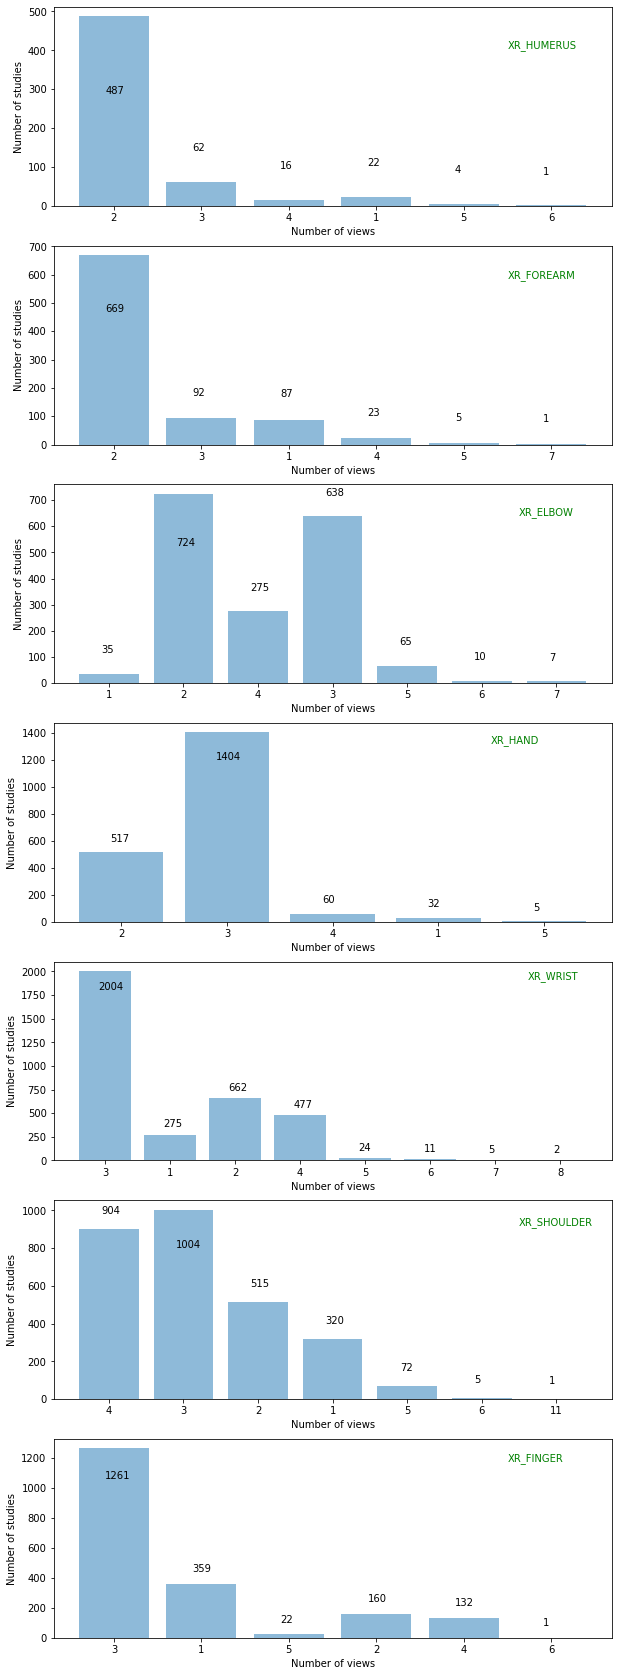

In [55]:
# plot the view count vs number of studies per study type data 
fig = plt.figure(figsize=(10, 30))
for i, view_type in enumerate(view_count):
    ax = fig.add_subplot(7, 1, i+1)
    view = view_count[view_type]
    # text in the plot
    m = max(view.values())
    for i, v in enumerate(view.values()):
        if v==m: ax.text(i-0.1, v - 200, str(v))
        else: ax.text(i-0.1, v + 80, str(v))
    ax.text(i - 0.5, m - 80, view_type, color='green')
    # plot the bar chart
    x_pos = np.arange(len(view))
    plt.bar(x_pos, view.values(), align='center', alpha=0.5)
    plt.xticks(x_pos,  view.keys())
    plt.xlabel('Number of views')
    plt.ylabel('Number of studies')
plt.show()
#fig.savefig('images/nsvc.jpg', bbox_inches='tight', pad_inches=0) # name=number of studies view count

Most of the studies contain 2, 3 or 4 views